In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import shutil

# Path to the metadata CSV file
metadata_path = r'C:\Users\viswa\Desktop\Project-X\HAM10000_metadata.csv'
images_path = r'C:\Users\viswa\Desktop\Project-X\HAM10000_images'

# Load the metadata
df = pd.read_csv(metadata_path)

# Split the data into train and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Create directories for train and test data
train_dir = r'HAM10000_sampled\train'
test_dir = r'HAM10000_sampled\test'
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Function to copy files to their respective directories
def copy_files(df, source, destination):
    for _, row in df.iterrows():
        filename = row['image_id'] + '.jpg'
        class_label = row['dx']
        class_dir = os.path.join(destination, class_label)
        os.makedirs(class_dir, exist_ok=True)
        src_path = os.path.join(source, filename)
        dst_path = os.path.join(class_dir, filename)
        if os.path.exists(src_path):  # Ensure the source file exists
            shutil.copyfile(src_path, dst_path)

# Copy train and test files
copy_files(train_df, images_path, train_dir)
copy_files(test_df, images_path, test_dir)

# Verify the directory structure
for category in os.listdir(train_dir):
    category_path = os.path.join(train_dir, category)
    if os.path.isdir(category_path):
        print(f"Category: {category}, Number of images: {len(os.listdir(category_path))}")

for category in os.listdir(test_dir):
    category_path = os.path.join(test_dir, category)
    if os.path.isdir(category_path):
        print(f"Category: {category}, Number of images: {len(os.listdir(category_path))}")


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\viswa\\Desktop\\Project-X\\HAM10000_metadata.csv'

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)



Found 6412 images belonging to 7 classes.
Found 1600 images belonging to 7 classes.


In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=[early_stopping]
)




Epoch 1/50


201/201 [==============================] - 169s 831ms/step - loss: 1.0625 - accuracy: 0.6645 - val_loss: 0.9061 - val_accuracy: 0.6706
Epoch 2/50
201/201 [==============================] - 59s 294ms/step - loss: 0.9456 - accuracy: 0.6700 - val_loss: 0.8652 - val_accuracy: 0.6875
Epoch 3/50
201/201 [==============================] - 61s 302ms/step - loss: 0.9025 - accuracy: 0.6726 - val_loss: 0.8286 - val_accuracy: 0.6762
Epoch 4/50
201/201 [==============================] - 63s 311ms/step - loss: 0.8787 - accuracy: 0.6871 - val_loss: 0.8177 - val_accuracy: 0.6869
Epoch 5/50
201/201 [==============================] - 65s 324ms/step - loss: 0.8479 - accuracy: 0.6881 - val_loss: 0.7835 - val_accuracy: 0.7106
Epoch 6/50
201/201 [==============================] - 64s 316ms/step - loss: 0.8218 - accuracy: 0.6893 - val_loss: 0.7827 - val_accuracy: 0.6988
Epoch 7/50
201/201 [==============================] - 64s 316ms/step - loss: 0.7969 - accuracy: 0.7004 - val_loss: 0.7482 - v

In [4]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc}')


Found 2003 images belonging to 7 classes.
63/63 [==============================] - 44s 707ms/step - loss: 0.7586 - accuracy: 0.7369
Test accuracy: 0.7368946671485901


In [6]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the saved model
model = load_model('dermatological_disease_detection_model.h5')

# Function to load and preprocess the image
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(128, 128))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img_array

# Path to the image you want to predict
img_path = r'C:\Users\viswa\Downloads\meleonma_test_image.jpeg'

# Load and preprocess the image
img = load_and_preprocess_image(img_path)

# Make the prediction
predictions = model.predict(img)
print(predictions)

# Determine the predicted class
predicted_class_index = np.argmax(predictions)
class_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
predicted_class = class_labels[predicted_class_index]
print(f"Predicted class: {predicted_class}")


1/1 [==============================] - 0s 224ms/step
[[3.0922118e-04 3.7610956e-05 8.4677108e-02 5.6829340e-06 7.9174745e-01
  1.2321881e-01 4.0594509e-06]]
Predicted class: mel


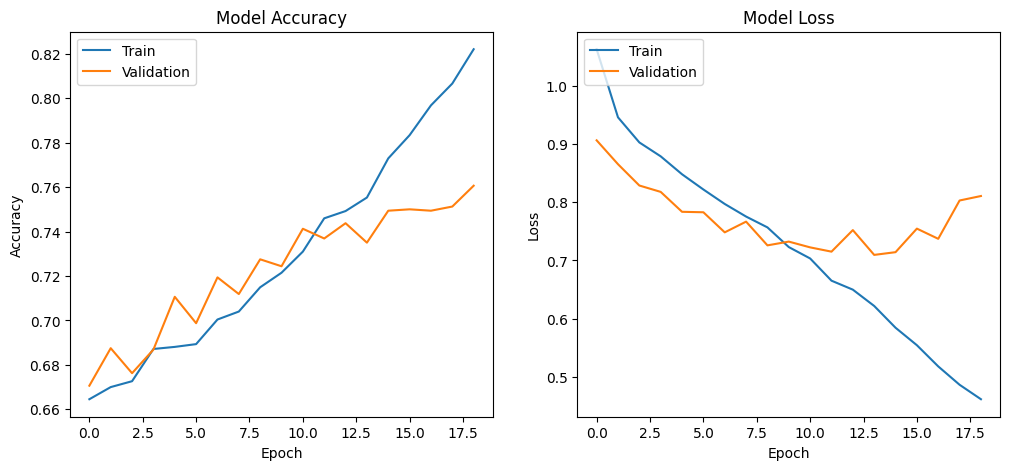

In [8]:

# Plot training & validation accuracy values
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


63/63 [==============================] - 16s 250ms/step


<Axes: >

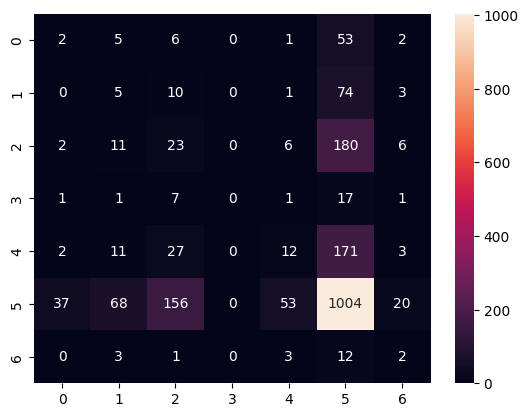

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d')


In [10]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred_classes, target_names=class_labels))


              precision    recall  f1-score   support

       akiec       0.05      0.03      0.04        69
         bcc       0.05      0.05      0.05        93
         bkl       0.10      0.10      0.10       228
          df       0.00      0.00      0.00        28
         mel       0.16      0.05      0.08       226
          nv       0.66      0.75      0.70      1338
        vasc       0.05      0.10      0.07        21

    accuracy                           0.52      2003
   macro avg       0.15      0.15      0.15      2003
weighted avg       0.48      0.52      0.50      2003



c:\Users\viswa\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\viswa\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\viswa\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [12]:
import joblib

# Assuming 'model' is your trained model object
joblib.dump(model, 'skin_disease_model.pkl')


['skin_disease_model.pkl']